## Title :
Performance comparison of different SOTAs

## Description :
The goal of this exercise is to compare different architectures on speed, size and performance.
Your final plot may resemble the one below:

<img src="../fig/fig.png" style="width: 500px;">

To read more about <a href="http://www.image-net.org" target="_blank">Imagenet Dataset.</a>

## Instructions :

- Load the data and choose only the first 100 images from the validation dataset.
- Using the helper code obtain the model statistics for each of the following SOTAs below:
    - VGG16 
    - VGG19
    - InceptionNetV3
    - ResNet50 
    - MobileNetV2 

## Hints :

<a href="https://keras.io/guides/sequential_model/" target="_blank">model.layers</a> Accesses layers of the model

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear" target="_blank">tf.keras.activations.linear</a> Linear activation function

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model" target="_blank">model.predict()</a> Used to predict the values given the model

<a href="https://numpy.org/doc/stable/reference/generated/numpy.argsort.html" target="_blank">np.argsort()</a> Returns the indices that would sort an array.

<a href="https://keras.io/api/applications/vgg/#vgg16-function" target="_blank">tf.keras.applications.VGG16</a> Instantiates the VGG16 model.

<a href="https://keras.io/api/applications/vgg/#vgg19-function" target="_blank">tf.keras.applications.VGG19</a> Instantiates the VGG16 model.

<a href="https://keras.io/api/applications/resnet/#resnet50-function" target="_blank">tf.keras.applications.ResNet50</a> Instantiates the ResNet50 architecture.

<a href="https://keras.io/api/applications/inceptionv3/" target="_blank">tf.keras.applications.InceptionV3</a> Instantiates the Inception v3 architecture.

<a href="https://keras.io/api/applications/mobilenet/#mobilenetv2-function" target="_blank">tf.keras.applications.MobileNetV2</a> Instantiates the MobileNetV2 architecture.


<a href="https://colab.research.google.com/drive/15FadhcLm50_ZO-uxgnm1l_g0gWnGwCzi?usp=sharing" target="_blank" >
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

# Performance comparision on SOTAs
**(Note: This notebook will not run on Ed. Please click the button above to run in Google Colab)**

In [9]:
# Import required libraries
import sys, os, time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
colors = ['k', 'g', 'r','b','c']
plt.style.use('seaborn-whitegrid')
from helper import ellipse
import pickle

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
import timeit

/tmp/ipykernel_205307/760688068.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Loading the data

In [51]:
# Useful dictionary to go from label index to actual label
with open('idx2name2.pkl', 'rb') as handle:
    keras_idx_to_name = pickle.load(handle)

In [5]:
# Loading input image and labels
images = np.load("/course/data/x_val.npy") # loaded as RGB
labels = np.load("/course/data/y_val.npy")

# Taking only 100 samples for quicker computation
x_val = images[:100]
y_val = labels[:100]
# One hot encoding the labels
y_val_one_hot = to_categorical(y_val, 1000)

FileNotFoundError: [Errno 2] No such file or directory: '/course/data/x_val.npy'

In [21]:
from keras.preprocessing.image import ImageDataGenerator 

generator = ImageDataGenerator(validation_split=0.2)
img_train = generator.flow_from_directory(directory="Validation Data/Validation Data", subset = "training", shuffle = True, batch_size = 32, target_size=(160,160))
# img_val = generator.flow_from_directory(directory="Validation Data/Validation Data", subset = "validation", shuffle = True, batch_size=32, target_size=(160,160))

Found 1600 images belonging to 15 classes.


In [22]:
img_train[0][1].shape

(32, 15)

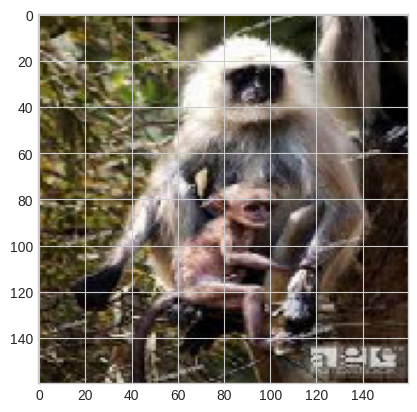

In [18]:
# Print a sample image and set the label as title
# plt.title(___)

import random
from tensorflow.keras.preprocessing import image

# plt.imshow(random.choice(list(img_train)))

sample = image.load_img("Validation Data/Validation Data/Monkey/Monkey (86).jpeg", target_size = (160,160))
plt.imshow(sample)

### ⏸ What is the label for the first image in the validation set?
**(Please answer this in quiz)**


#### A. Cabbage Butterfly
#### B. Mixing bowl
#### C. Wok
#### D. French horn

In [ ]:
# Submit an answer choice as a string below (eg. if you choose option C, put 'C')
answer1 = '___'

## Benchmark models

In [56]:
# Helper function to get key stats
# (evaluation speed, top-1 % accuracy, total model parameters)
def model_stats(model,x_val,y_val, name):
    #Time for evaluation
    time = timeit.timeit(lambda: model.predict(x_val, verbose=1), number=1)
    # timeit.timeit(stmt, setup, timer, number)
    # stmt the statement you want to measure; it defaults to ‘pass’.
    # setup the code that you run before running the stmt; it defaults to ‘pass’. We generally use this to import the required modules for our code.
    # timer a timeit.Timer object; it usually has a sensible default value so you don’t have to worry about it.
    # number the number of executions you’d like to run the stmt.

    # The timeit.timeit() function expects a callable object, 
    # if timeit.timeit(model.predict(x_val, verbose=1), number=1): calling the model.predict() method directly inside timeit.timeit(), already run the function
    # lambda: model.predict(x_val, verbose=1): creating an anonymous function (without input) and not running/calling it

    # Accuracy
    y_pred = model.predict(x_val)
    top_1 = np.any(np.argsort(y_pred)[:,-1:].T == y_val.argmax(axis=1),axis=0).mean()
    # np.argsort() default axis=-1
    # np.any() Test whether any array element along a given axis evaluates to True. Returns single boolean if axis is None
    
    # Model size 
    params = model.count_params()
    return (time,top_1,params,name)


## SOTA architectures

For this exercise, we will consider the following SOTAs:
- VGG16
- VGG19
- InceptionV3
- ResNet50
- MobileNet

In [57]:
# VGG16 stats
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Preprocess step
# We need to call the data because some preprocess steps
# change the value inplace
# x_val = np.load("/course/data/x_val.npy") # loaded as RGB
# x_val = x_val[:100]
# x_val = preprocess_input(x_val)

generator = ImageDataGenerator(preprocessing_function = preprocess_input)
img_train = generator.flow_from_directory(directory="Validation Data/Validation Data", batch_size=32, target_size=(224,224))

# Call the VGG16 model
model = VGG16()

# Collect stats 
vgg16stats = model_stats(model,img_train[0][0], img_train[0][1],'VGG16')

Found 2000 images belonging to 15 classes.
1/1 [==============================] - 2s 2s/step


In [48]:
np.argsort(model.predict(img_train[0][0]))

1/1 [==============================] - 2s 2s/step


array([[532, 418, 709, ..., 366, 380, 379],
       [438, 604, 633, ..., 256, 388, 361],
       [147, 945, 148, ..., 340, 282, 292],
       ...,
       [933, 438, 925, ..., 362, 361, 388],
       [839, 863, 411, ..., 302, 307, 305],
       [623,  95, 320, ..., 345, 348, 958]])

In [ ]:
# VGG19 stats
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

x_val = np.load("/course/data/x_val.npy") # loaded as RGB
x_val = x_val[:100]
x_val = preprocess_input(x_val)

# Call the VGG19 model
model = VGG19()

# Collect stats 
vgg19stats = model_stats(model,x_val,'VGG19')

In [ ]:
# Inception Stats
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input

x_val = np.load("/course/data/x_val.npy") # loaded as RGB
x_val = x_val[:100]
x_val = preprocess_input(x_val)

# Call the InceptionV3 model
model = InceptionV3()

# Collect stats 
inceptionstats = model_stats(model,x_val,'Inception')

In [ ]:
# Resnet50 stats
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

x_val = np.load("/course/data/x_val.npy") # loaded as RGB
x_val = x_val[:100]
x_val = preprocess_input(x_val)

# Call the ResNet50 model
model = ResNet50()

# Collect stats 
resnetstats = model_stats(model,x_val,'Resnet50')

In [ ]:
# MobileNet stats
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
x_val = np.load("/course/data/x_val.npy") # loaded as RGB
x_val = x_val[:100]
x_val = preprocess_input(x_val)

# Call the MobielNetV2 model
model = MobileNetV2()

# Collect stats 
mobilestats = model_stats(model,x_val,'MobileNet')

### ⏸ Which SOTA architecture from above has the **highest** number of trainable parameters?
**(Please answer this in quiz)**

#### A. VGG-16
#### B. VGG-19
#### C. ResNet50
#### D. MobileNet

In [ ]:
# Submit an answer choice as a string below (eg. if you choose option C, put 'C')
answer2 = '___'

In [ ]:
# Use the helper code below 
# to plot the model stats for each SOTA
fig, ax  = plt.subplots(figsize=(10,6))
for i,val in enumerate([vgg16stats, vgg19stats, inceptionstats,resnetstats, mobilestats]):
    r = val[2]/10**9 + 0.04
    ellipse(val[0]/40,val[1],width=r,height=0.44*r,color = colors[i],ax=ax)
    ax.text(val[0]/40 + 0.035, val[1]+r/4+ 0.004, val[3], va='center', ha='center',fontsize=12)
    
ax.set_ylim([0.6,0.85])
ax.set_ylabel('Top-1 accuracy [%]',fontsize=20)
ax.set_xlabel('Time for evaluation [s]',fontsize=20)
ax.set_xticklabels(range(0,60,8));
ax.set_yticklabels(range(50,110,10));
for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(3)
  ax.spines[axis].set_color('k')
  # !!!!!!

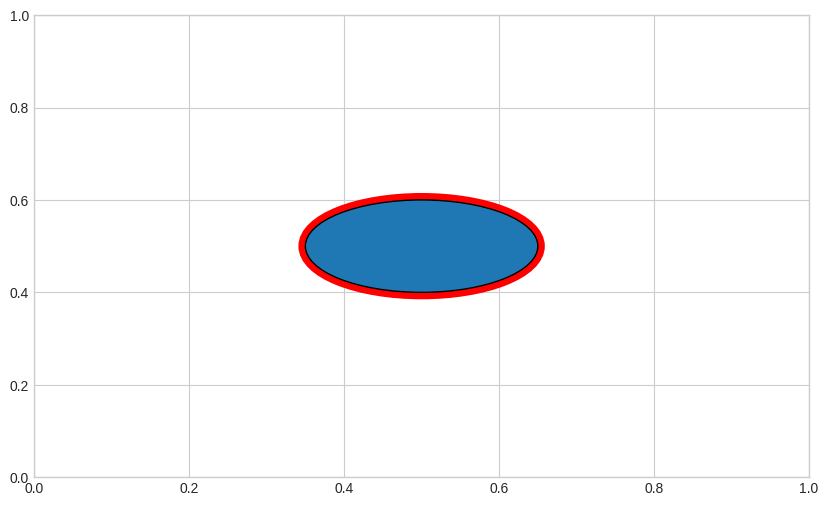

: 

In [69]:
from matplotlib.patches import Ellipse
from matplotlib.patheffects import withStroke
fig, ax  = plt.subplots(figsize=(10,6))
ellipse = Ellipse((0.5, 0.5), width=0.3, height=0.2, clip_on=False, linewidth=1,
                      edgecolor='black',
                      path_effects=[withStroke(linewidth=10, foreground='r')])
ax.add_artist(ellipse)

### 🍲 Larger dataset

Go back and take a larger sample of images, do your results remain consistent?

In [ ]:
# Type your answer within in the quotes given
answer3 = '___'